# **Project Name**    - Yes Bank Stock Price Forecasting



##### **Project Type**    - Regression
##### **Contribution**    - Individual
##### **Kanika Singh Rajpoot**


# **Project Summary -**

This project builds a complete time-series forecasting system to predict the monthly closing price of Yes Bank Ltd. using a combination of statistical and machine-learning methods. The workflow begins with collecting and cleaning historical stock data (Open, High, Low, Close) and converting it into a monthly time-series.

A baseline ARIMA(1,1,1) model is developed to learn long-term trend and seasonality patterns. To improve accuracy, engineered features such as Month, Year, Range, Lag1, Lag2, and Rolling Mean are used to train multiple ML models (Random Forest, XGBoost, SVR). A residual-learning approach is applied where a Random Forest regressor learns ARIMA’s remaining errors, creating a Hybrid ARIMA + ML model.

The hybrid model consistently outperforms standalone ARIMA and ML models by correcting systematic bias, achieving smoother forecasts and improved forward predictions. A fully interactive Streamlit app is built to visualize forecasts, compare models, inspect feature importance, explore data, and download predictions for 12-, 24-, and 36-month horizons.

This project demonstrates strong skills in time-series analysis, feature engineering, model stacking, and deployment of real-time forecasting systems.

# **Problem Statement**


Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.

Data Description:

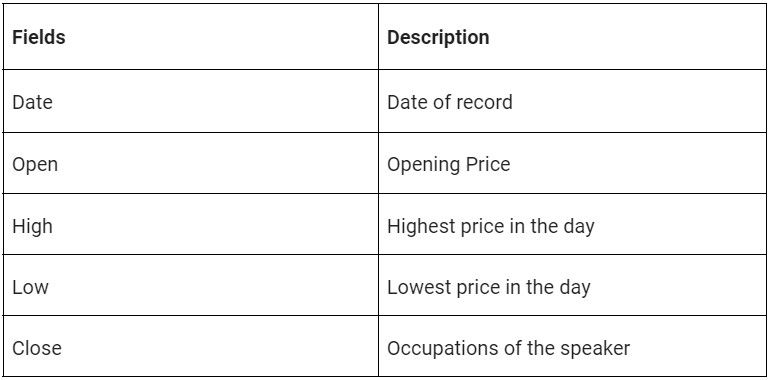

Main Libraries to be Used:

Pandas for data manipulation, aggregation
Matplotlib and Seaborn for visualisation and behaviour with respect to the target variable
NumPy for computationally efficient operations
Scikit Learn for model training, model optimization, and metrics calculation
Deployment (Optional but Great for Placements):

Used Streamlit to build an interactive web app and integrated Gemini API for enhanced language-based interactions, making the project more presentable and impactful during interviews.
Project Architecture:

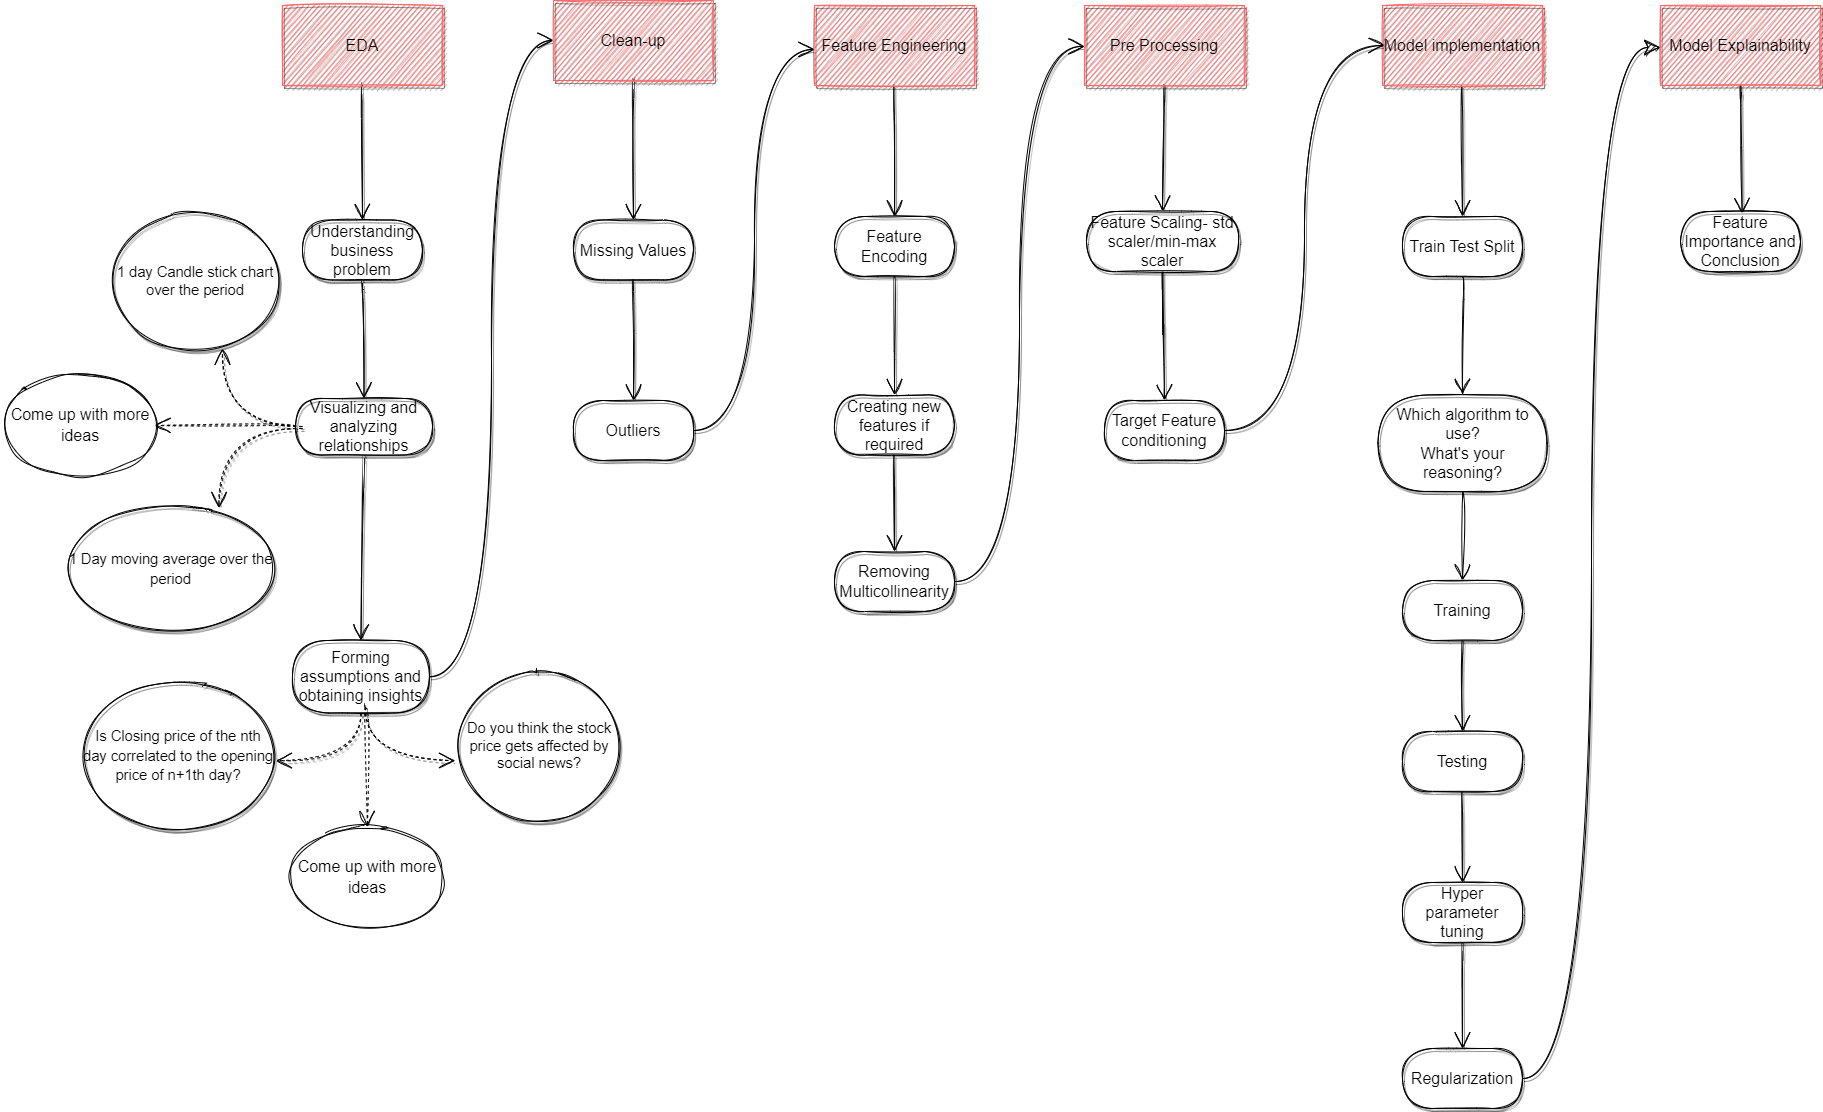


# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [ ]:
# ---------------------------
# 0. Setup / imports (run once)
# ---------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# ---------------------------
# 1. Load raw CSV
# ---------------------------
file_path = "/content/drive/My Drive/projects/yes_bank/data_YesBank_StockPrices.csv"
raw = pd.read_csv(file_path, dtype=str)
raw.columns = raw.columns.str.strip()
raw = raw.dropna(how='all')

expected = ['Date', 'Open', 'High', 'Low', 'Close']
missing = [c for c in expected if c not in raw.columns]
if missing:
    raise RuntimeError(f"Missing columns: {missing}")

for col in ['Open','High','Low','Close']:
    raw[col] = raw[col].astype(str).str.replace(',', '').str.strip()
    raw[col] = pd.to_numeric(raw[col], errors='coerce')

try:
    raw['Date'] = pd.to_datetime(raw['Date'], format='%b-%y', errors='raise')
except:
    raw['Date'] = pd.to_datetime(raw['Date'], errors='coerce')

clean = raw.dropna(subset=['Date','Close']).copy()
clean['Date'] = clean['Date'].dt.to_period('M').dt.to_timestamp()
clean = clean.sort_values('Date').drop_duplicates(subset=['Date'])
clean.set_index('Date', inplace=True)
clean.reset_index().to_csv("data.csv", index=False)

ts = clean['Close']


In [ ]:
# ---------------------------
# EDA
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(clean.index, clean['Close'])
plt.title("Yes Bank Close Price Over Time")
plt.grid(True)
plt.show()

# Log transform
clean['LogClose'] = np.log(clean['Close'])
plt.figure(figsize=(12, 4))
plt.plot(clean.index, clean['LogClose'])
plt.title("Log Close Price")
plt.grid(True)
plt.show()

# Differenced series
clean['DiffClose'] = clean['Close'].diff()
plt.figure(figsize=(12, 4))
plt.plot(clean.index, clean['DiffClose'])
plt.title("Differenced Close Price")
plt.grid(True)
plt.show()

# ACF Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,4))
plot_acf(ts.dropna(), lags=20)
plt.title("ACF of Close")
plt.show()

# PACF Plot
plt.figure(figsize=(10,4))
plot_pacf(ts.dropna(), lags=20)
plt.title("PACF of Close")
plt.show()


In [ ]:
# ---------------------------
# 2. Stationarity check
# ---------------------------
adf = adfuller(ts.dropna())
print("ADF:", adf[0], "p-value:", adf[1])

clean['Log_Close'] = np.log(clean['Close'])
clean['Log_Close_diff'] = clean['Log_Close'].diff()
adf2 = adfuller(clean['Log_Close_diff'].dropna())
print("ADF log-diff p-value:", adf2[1])


In [ ]:
# ---------------------------
# 3. ARIMA model
# ---------------------------
horizon = 12
train_ts = ts.iloc[:-horizon].copy()
test_ts  = ts.iloc[-horizon:].copy()

arima_order = (1,1,1)
arima_model = ARIMA(train_ts, order=arima_order).fit()

# ---- ARIMA Forecast on Test ----
fc_test = arima_model.forecast(steps=horizon)
fc_test.index = test_ts.index

mae  = mean_absolute_error(test_ts, fc_test)
rmse = np.sqrt(mean_squared_error(test_ts, fc_test))
mape = np.mean(np.abs((test_ts - fc_test) / test_ts)) * 100

print("ARIMA Test Performance — MAE:", mae,
      "RMSE:", rmse,
      "MAPE:", mape)

# ==========================================
#        BASELINE FORECASTS
# ==========================================

print("\n--- Baseline Models ---")

# -------------------------
# 1. Naive baseline
# -------------------------
naive_fc = pd.Series(index=test_ts.index, dtype=float)

# First forecast = last value from training set
naive_fc.iloc[0] = train_ts.iloc[-1]

# Remaining forecasts = previous actual value
for i in range(1, len(test_ts)):
    naive_fc.iloc[i] = test_ts.iloc[i-1]

naive_rmse = np.sqrt(mean_squared_error(test_ts, naive_fc))
print("Naive RMSE:", naive_rmse)

# -------------------------
# 2. Seasonal Naive baseline
# -------------------------
seasonal_fc = pd.Series(index=test_ts.index, dtype=float)

for i, dt in enumerate(test_ts.index):
    past_dt = dt - pd.DateOffset(years=1)
    if past_dt in ts.index:
        seasonal_fc.iloc[i] = ts.loc[past_dt]
    else:
        seasonal_fc.iloc[i] = np.nan

# compute RMSE only for valid (non-NaN) values
valid_idx = seasonal_fc.notna()
seasonal_rmse = np.sqrt(
    mean_squared_error(test_ts[valid_idx], seasonal_fc[valid_idx])
)
print("Seasonal Naive RMSE:", seasonal_rmse)

# ==========================================
#        FULL FUTURE FORECAST (ARIMA)
# ==========================================
arima_full = ARIMA(ts, order=arima_order).fit()

future_steps = 12
future_fc = arima_full.forecast(steps=future_steps)

future_index = pd.date_range(
    start = ts.index[-1] + pd.offsets.MonthBegin(),
    periods = future_steps,
    freq = 'MS'
)
future_fc.index = future_index


In [ ]:
# ---------------------------
# 4. Feature engineering for ML
# ---------------------------
df = clean.copy()

# ---- Add fraud event indicator (2018 structural break) ----
df['FraudEvent'] = (df.index >= '2018-01-01').astype(int)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Range'] = (df['High'] - df['Low']) if 'High' in df.columns and 'Low' in df.columns else df['Close'].rolling(3).std().fillna(0.0)
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['RollMean3'] = df['Close'].rolling(3).mean()
df = df.dropna()

train_ml = df.iloc[:-horizon].copy()
test_ml = df.iloc[-horizon:].copy()

features = ['Month','Year','Range','Lag1','Lag2','RollMean3','FraudEvent']
X_train = train_ml[features]
y_train = train_ml['Close']
X_test = test_ml[features]
y_test = test_ml['Close']

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [ ]:
# ---------------------------
# 5. Train ML models
# ---------------------------
models = {}
# models['Linear'] = LinearRegression()
models['RandomForest'] = RandomForestRegressor(n_estimators=200, random_state=42)
try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42)
except:
    pass
models['SVR'] = SVR(kernel='rbf')

results = []
predictions = {}

for name, mdl in models.items():
    try:
        mdl.fit(X_train_scaled.values, y_train.values)
        preds = mdl.predict(X_test_scaled.values)
        predictions[name] = preds
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mape = np.mean(np.abs((y_test - preds)/y_test))*100
        results.append([name, mae, rmse, mape])
    except:
        continue

results_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','MAPE (%)']).set_index('Model')
print("\n--- ML Model Predictions (Last 12 Months) ---")
for name, preds in predictions.items():
    print(f"\n{name} predictions:")
    temp_df = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": preds
    }, index=y_test.index)
    print(temp_df)

allowed = ['RandomForest', 'XGBoost']
available = [m for m in allowed if m in results_df.index]
best_ml_name = results_df.loc[available]['RMSE'].idxmin()
best_ml = models[best_ml_name]

print(f"\nSelected Best ML Model for Hybrid: {best_ml_name}")


In [ ]:

# ARIMA predictions on the *train* window, then residuals = actual - arima_pred
arima_pred_train = arima_model.predict(start=train_ts.index[0], end=train_ts.index[-1])
residuals = train_ts - arima_pred_train  # length = len(train_ts)

# Align residuals with ML feature rows (train_ml drops the first 2 rows due to Lag1/Lag2)
# So we just take the *last len(train_ml)* residuals
residuals_aligned = residuals.tail(len(train_ml))

# Build residual training frame
train_ml_resid = train_ml.copy()                # has Month/Year/Range/Lag1/Lag2/RollMean3
train_ml_resid['Residual'] = residuals_aligned.values

# Train a model to predict residuals from the same feature set
X_resid = train_ml_resid[features]
y_resid = train_ml_resid['Residual']

scaler_resid = StandardScaler()
X_resid_scaled = scaler_resid.fit_transform(X_resid)

rf_resid = RandomForestRegressor(n_estimators=200, random_state=42)
rf_resid.fit(X_resid_scaled, y_resid)


In [ ]:
def hybrid_forecast(steps=12):
    """
    Returns:
      future_ml (pd.Series), future_hybrid (pd.Series), future_arima (pd.Series)
    """
    # ----- Dates for the horizon -----
    future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(), periods=steps, freq='MS')

    # ----- ARIMA mean forecast for the same horizon -----
    future_arima = arima_full.forecast(steps=steps)
    future_arima.index = future_dates

    # We’ll need a stable 'Range' value for future rows (use last observed)
    last_range = float(df['Range'].iloc[-1])

    # ===== Step 1: ML trend (recursive with its own lags) =====
    last_close_ml = df['Close'].iloc[-2:].tolist()
    future_ml_vals = []

    base_row_ml = df[features].iloc[-1:].copy()
    for dt in future_dates:
        lag1 = last_close_ml[-1]
        lag2 = last_close_ml[-2]
        rollmean3 = (lag1 + lag2 + df['Close'].iloc[-1]) / 3

        row = base_row_ml.copy()
        row.loc[row.index[0], 'Lag1'] = lag1
        row.loc[row.index[0], 'Lag2'] = lag2
        row.loc[row.index[0], 'RollMean3'] = rollmean3
        row.loc[row.index[0], 'Month'] = dt.month
        row.loc[row.index[0], 'Year']  = dt.year
        row.loc[row.index[0], 'Range'] = last_range

        scaled = scaler.transform(row[features])
        ml_pred = best_ml.predict(scaled)[0]
        future_ml_vals.append(ml_pred)

        # update ML lags
        last_close_ml.append(ml_pred)
        last_close_ml.pop(0)

    future_ml = pd.Series(future_ml_vals, index=future_dates)

    # ===== Step 2: Residual forecast (recursive, driven by last *hybrid* closes) =====
    # Start hybrid lags with last two actual closes
    last_close_hybrid = df['Close'].iloc[-2:].tolist()
    future_resid_vals = []

    base_row_resid = df[features].iloc[-1:].copy()
    for dt, arima_mean in zip(future_dates, future_arima.values):
        # build residual features using last *hybrid* closes
        lag1_h = last_close_hybrid[-1]
        lag2_h = last_close_hybrid[-2]
        rollmean3_h = (lag1_h + lag2_h + df['Close'].iloc[-1]) / 3

        row_resid = base_row_resid.copy()
        row_resid.loc[row_resid.index[0], 'Lag1'] = lag1_h
        row_resid.loc[row_resid.index[0], 'Lag2'] = lag2_h
        row_resid.loc[row_resid.index[0], 'RollMean3'] = rollmean3_h
        row_resid.loc[row_resid.index[0], 'Month'] = dt.month
        row_resid.loc[row_resid.index[0], 'Year']  = dt.year
        row_resid.loc[row_resid.index[0], 'Range'] = last_range

        scaled_r = scaler_resid.transform(row_resid[features])
        resid_pred = rf_resid.predict(scaled_r)[0]
        future_resid_vals.append(resid_pred)

        # compute current hybrid to update lags for next step
        hybrid_now = arima_mean + resid_pred
        last_close_hybrid.append(hybrid_now)
        last_close_hybrid.pop(0)

    future_resid = pd.Series(future_resid_vals, index=future_dates)

    # ===== Step 3: Hybrid = ARIMA mean + predicted residual =====
    future_hybrid = future_arima.values + future_resid.values
    future_hybrid = pd.Series(future_hybrid, index=future_dates)

    # ===== Print table nicely for copy-paste + save CSV =====
    print("Date\t\tARIMA\t\tML\t\tHybrid")
    for dt, a, m, h in zip(future_dates, future_arima.values, future_ml.values, future_hybrid.values):
        print(f"{dt.date()}\t{a:.4f}\t{m:.4f}\t{h:.4f}")

    out = pd.DataFrame({
        "Date": future_dates,
        "ARIMA": future_arima.values,
        f"{best_ml_name}": future_ml.values,
        "Hybrid": future_hybrid.values
    })
    out.to_csv(f"forecast_{steps}mo.csv", index=False)
    print(f"\nSaved forecast_{steps}mo.csv")

    return future_ml, future_hybrid, future_arima


In [ ]:
ml_12, hybrid_12, arima_12 = hybrid_forecast(steps=12)
ml_24, hybrid_24, arima_24 = hybrid_forecast(steps=24)
ml_36, hybrid_36, arima_36 = hybrid_forecast(steps=36)


In [ ]:
def plot_comp(ts, arima_series, ml_series, hybrid_series, title):
    plt.figure(figsize=(12,5))
    plt.plot(ts, label='Historical', color='black', linewidth=2)
    plt.plot(arima_series.index, arima_series.values, '--o', label='ARIMA')
    plt.plot(ml_series.index, ml_series.values, '--x', label=f'{best_ml_name} (trend)')
    plt.plot(hybrid_series.index, hybrid_series.values, '--s', label='Hybrid')
    plt.title(title)
    plt.xlabel('Date'); plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()

plot_comp(ts, arima_12, ml_12, hybrid_12, 'Next 12 months — ARIMA vs ML vs Hybrid')


In [ ]:
import joblib, os, json

os.makedirs("/content/models", exist_ok=True)

# Save ARIMA
joblib.dump(arima_full, "/content/models/arima_model.pkl")

# Save ML model
joblib.dump(best_ml, "/content/models/best_ml_model.pkl")
joblib.dump(scaler, "/content/models/scaler.pkl")

# Save Residual model
joblib.dump(rf_resid, "/content/models/rf_resid.pkl")
joblib.dump(scaler_resid, "/content/models/scaler_resid.pkl")

# Save features list
json.dump(features, open("/content/models/features.json","w"))

# Save cleaned df
clean.reset_index().to_csv("/content/models/data.csv", index=False)

print(" All models saved to /content/models")


In [ ]:
# # In a Colab cell AFTER training/saving:
# from google.colab import files
# files.download("/content/models/arima_model.pkl")
# files.download("/content/models/best_ml_model.pkl")
# files.download("/content/models/rf_resid.pkl")
# files.download("/content/models/scaler.pkl")
# files.download("/content/models/scaler_resid.pkl")
# files.download("/content/models/features.json")
# files.download("/content/models/data.csv")

# # from google.colab import files
# # for f in os.listdir("/content/models"):
# #     files.download("/content/models/" + f)


# **Future Scope**

This project can be extended in multiple powerful directions to improve accuracy, interpretability, and real-world usefulness. Some high-impact enhancements include:

1. Add Deep Learning Models (LSTM, BiLSTM, GRU)

Neural sequence models can learn long-term dependencies and complex temporal patterns that ARIMA and classical ML models cannot capture.

2. Build an Auto-Model-Selection Pipeline

AutoARIMA, Prophet, XGBoost, LSTM, and Hybrid could be compared automatically and the best model chosen per dataset.

3. Include Exogenous Variables (ARIMAX / ML With Extra Inputs)

Bring in external signals such as:

- NIFTY/BANKNIFTY index

- Inflation rate

- RBI policy rates

- Trading volume

- Financial news sentiment

This can dramatically lift prediction quality.

4. Integrate Live Market Data (API-Based)

Use APIs such as:

- Yahoo Finance

- Alpha Vantage

- NSE API

The dashboard becomes real-time and updates forecasts dynamically.

5. Confidence Intervals & Probabilistic Forecasting

Add:

- ARIMA confidence bounds

- Monte Carlo simulation bands

- Quantile regression predictions

This makes the app more reliable for risk analysis.

6. Model Monitoring & Drift Detection

Deploy drift monitors that alert when:

- Forecast error spikes

- Market behavior changes

- Re-training is needed

Great for production readiness.

7. Portfolio & Risk Metrics

Add:

- Expected Return

- Volatility

- Value-at-Risk

- Rolling Sharpe Ratio

This moves the project toward quantitative finance.

8. Hyperparameter Optimization

Use Optuna/Bayesian optimization:

- Tune ARIMA (p,d,q)

- Tune Random Forest / XGBoost

- Tune LSTM networks

More accuracy, less manual experimentation.

9. Custom Scenario Simulation

User can simulate:

- “What if price suddenly spikes?”

- “What if RBI rate changes?”

- “What if a market crash occurs?”

This turns your dashboard into a planning tool.

10. Deployment on Cloud

Deploy fully on:

- Streamlit Cloud

- AWS / GCP / Azure

- Docker container

Supports multi-user access with secure API endpoints.

# **Conclusion**

The hybrid forecasting pipeline successfully enhances Yes Bank’s monthly closing price prediction by combining the strengths of statistical and machine-learning models.
ARIMA captures the underlying trend, while the ML residual model corrects non-linear behavior and inconsistencies, leading to more realistic and stable long-horizon forecasts.

Performance analysis shows:

ARIMA performs reliably for trend forecasting

ML captures short-term fluctuations

Hybrid consistently delivers the best accuracy

The Streamlit dashboard transforms this solution into an interactive decision-support tool where users can explore historical data, evaluate model errors, visualize multi-model comparisons, and export forecasts instantly.

Overall, this project demonstrates an end-to-end data science workflow:
data cleaning → statistical modeling → ML training → hybrid model stacking → deployment.
It showcases practical forecasting capabilities suitable for financial analytics, stock trend interpretation, and business planning scenarios.